## Cost Profiling openEO processes (UDP)

In this notebook we detail how one can profile the credit cost of a openEO process. Providing such information can by highly informative when sharing the process with other users, or when trying to optimize its credit usage. 

In this example we will profile the `max ndvi` udp as a function of the spatial and temporal input size.


In [2]:
import pandas as pd
import openeo

from openeo.extra.job_management import (
        CsvJobDatabase,
        ProcessBasedJobCreator,
        MultiBackendJobManager
    )


For this example we gather an existing APEx algorithm from the catalog, but it is also relatively easy to work with any other openEO process.

In [8]:
#process_graph_url = "https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/refs/heads/hv_notebook_fix/algorithm_catalog/vito/eurac_pv_farm_detection/openeo_udp/eurac_pv_farm_detection.json"

process_graph_url = "C:/Git_projects/apex_algorithms/algorithm_catalog/vito/eurac_pv_farm_detection/openeo_udp/eurac_pv_farm_detection.json"

## Prepare jobs database

In order to profile the openEO process, we will make use of openEO's `MultiBackendJobManager`. This Job manager requires oen to set up a dataframe which contains all input parameters for the jobs we wish to run.

Hence we will create a dataframe containing all combinations of the input variables over which we want to profile the openEO process. To make thes estimation more regirous, one can decide to run the openEO process for each region multiple times, and average over the evaluation metrics.



In [9]:
from utils import prepare_jobs_df

BASE_SPATIAL = {"west": 664000.0, "south": 5611120.0, "crs": "EPSG:32631", "srs": "EPSG:32631"}
BASE_TEMPORAL = '2024-01-01'

spatial_extents = [10000, 20000, 40000] #km extend
temporal_extents = [3, 6, 12] #months

jobs_df = prepare_jobs_df(spatial_extents, temporal_extents, BASE_SPATIAL, BASE_TEMPORAL)
print(jobs_df)

                                                bbox           temporal_extent
0  {'west': 5.318868004541495, 'south': 50.625959...  [2024-01-01, 2024-04-01]
1  {'west': 5.318868004541495, 'south': 50.625959...  [2024-01-01, 2024-07-01]
2  {'west': 5.318868004541495, 'south': 50.625959...  [2024-01-01, 2025-01-01]
3  {'west': 5.318868004541495, 'south': 50.622890...  [2024-01-01, 2024-04-01]
4  {'west': 5.318868004541495, 'south': 50.622890...  [2024-01-01, 2024-07-01]
5  {'west': 5.318868004541495, 'south': 50.622890...  [2024-01-01, 2025-01-01]
6  {'west': 5.318868004541495, 'south': 50.616238...  [2024-01-01, 2024-04-01]
7  {'west': 5.318868004541495, 'south': 50.616238...  [2024-01-01, 2024-07-01]
8  {'west': 5.318868004541495, 'south': 50.616238...  [2024-01-01, 2025-01-01]


## Creating the Job

Define the `start_job` function, which creates the actual job for each row in our jobs DataFrame.
Do note that the `MultiBackendJobManager` expects a start_joc functionality with the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_.

In [10]:
start_job = ProcessBasedJobCreator(namespace=process_graph_url)

## Running Jobs Using MultiBackendJobManager

With our spatial extents set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining an output file where the job tracker will store the job statuses and metadata.

### Steps to Run the Jobs:

1. Define the Output File:
   The output file will store the job tracker data, including job statuses and metadata.

2. Initialize the MultiBackendJobManager:
   We create an instance of the `MultiBackendJobManager` and add a backend of our choice. This backend will be responsible for executing the jobs.

3. Run Multiple Jobs:
   Use `manager.run_jobs` to create the desired jobs and send them to the backend.
   The output file, defined in step 1, will act as a the live job tracker and contain all the information from the original jobs DataFrame, as well as updates on the actual job statuses.

**Note** To run this code, provide an alternative job_tracker, as all the jobs in the max_ndvi_composite_profiler.csv have already been finalised.
This can be easily done by providing a new name for the job_tracker

In [11]:

# Initiate MultiBackendJobManager 
job_manager = MultiBackendJobManager()  
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
job_manager.add_backend("cdse", connection=connection, parallel_jobs=10)

job_tracker = 'jobs.csv'
job_db = CsvJobDatabase(path=job_tracker)
job_db.initialize_from_df(jobs_df)

job_manager.run_jobs(start_job=start_job, job_db=job_db)

Authenticated using refresh token.


NotImplementedError: Unsupported process definition source udp_id=None namespace='C:/Git_projects/apex_algorithms/algorithm_catalog/vito/eurac_pv_farm_detection/openeo_udp/eurac_pv_farm_detection.json'

Once the jobs have run, we reconnect to each job using the job-id and add the cost information into the dataframe. 
This step will become deprecated in the future as the job cost will be added to the job manager as a standard.

In [ ]:

df = pd.read_csv(job_tracker)
df

,spatial_extent,square_km,temporal_extent,months,status,id,start_time,cpu,memory,duration,backend_name,input_pixel,max_executor_memory,network_received,job_cost
0,"{'west': 5.318868004541495, 'south': 50.625959...",100.0,"['2020-01-01', '2020-02-01']",1,finished,j-24092315f4404a61acac5f7f0f8b8e07,2024-09-23T10:16:59.005988,327.59725417399994 cpu-seconds,2233173.9375 mb-seconds,132 seconds,cdse,46.40625 mega-pixel,1.6631202697753906 gb,5049020597 b,4.0
1,"{'west': 5.318868004541495, 'south': 50.625959...",100.0,"['2020-01-01', '2020-02-01']",1,finished,j-240923a569f341268a1adc986a972aa4,2024-09-23T10:17:14.009470,309.844807127 cpu-seconds,1636332.0703125 mb-seconds,146 seconds,cdse,46.40625 mega-pixel,1.6960525512695312 gb,5361895794 b,4.0
2,"{'west': 5.318868004541495, 'south': 50.625959...",100.0,"['2020-01-01', '2020-04-01']",3,finished,j-240923ea03f24e8283eb28daa8263ce6,2024-09-23T10:17:30.459242,907.283010235 cpu-seconds,7756178.021484377 mb-seconds,441 seconds,cdse,150.984375 mega-pixel,1.9598426818847656 gb,19885366328 b,6.0
3,"{'west': 5.318868004541495, 'south': 50.625959...",100.0,"['2020-01-01', '2020-04-01']",3,finished,j-240923108e014e75b1530684a8bb733e,2024-09-23T10:17:45.319290,753.8725804280001 cpu-seconds,3424297.0833333335 mb-seconds,256 seconds,cdse,150.984375 mega-pixel,1.7598495483398438 gb,18569459286 b,4.0
4,"{'west': 5.318868004541495, 'south': 50.622890...",400.0,"['2020-01-01', '2020-02-01']",1,finished,j-24092343b2504f0bbeabaef27eae1348,2024-09-23T10:18:04.326420,816.6876215210001 cpu-seconds,4150286.494791666 mb-seconds,208 seconds,cdse,163.53125 mega-pixel,1.6634178161621094 gb,9562284584 b,5.0
5,"{'west': 5.318868004541495, 'south': 50.622890...",400.0,"['2020-01-01', '2020-02-01']",1,finished,j-240923c68a5044748e3b50f71202d8af,2024-09-23T10:18:20.125327,671.035111319 cpu-seconds,3473766.541015625 mb-seconds,163 seconds,cdse,163.53125 mega-pixel,1.6620903015136719 gb,6368946943 b,4.0
6,"{'west': 5.318868004541495, 'south': 50.622890...",400.0,"['2020-01-01', '2020-04-01']",3,finished,j-240923de2cd5446abab26136ec6cafd9,2024-09-23T10:18:35.373765,2220.869635468 cpu-seconds,14486291.071647136 mb-seconds,469 seconds,cdse,534.640625 mega-pixel,2.1582069396972656 gb,42865444210 b,7.0
7,"{'west': 5.318868004541495, 'south': 50.622890...",400.0,"['2020-01-01', '2020-04-01']",3,finished,j-240923ae7f30451c8e92b5e7a5500371,2024-09-23T10:18:50.052960,1921.647162962 cpu-seconds,11258747.46295573 mb-seconds,367 seconds,cdse,534.640625 mega-pixel,2.222148895263672 gb,32632532500 b,7.0


# Metrics plots

Results are plotted to allow visual inspection.

The first plot shows cost as a function of the spatial and temporal extent. The second figure shows cost versus the amount of input data (pixels).

These visualisation can help estimate the openEO cost when one wishes to run the undelrying process on a larger scale


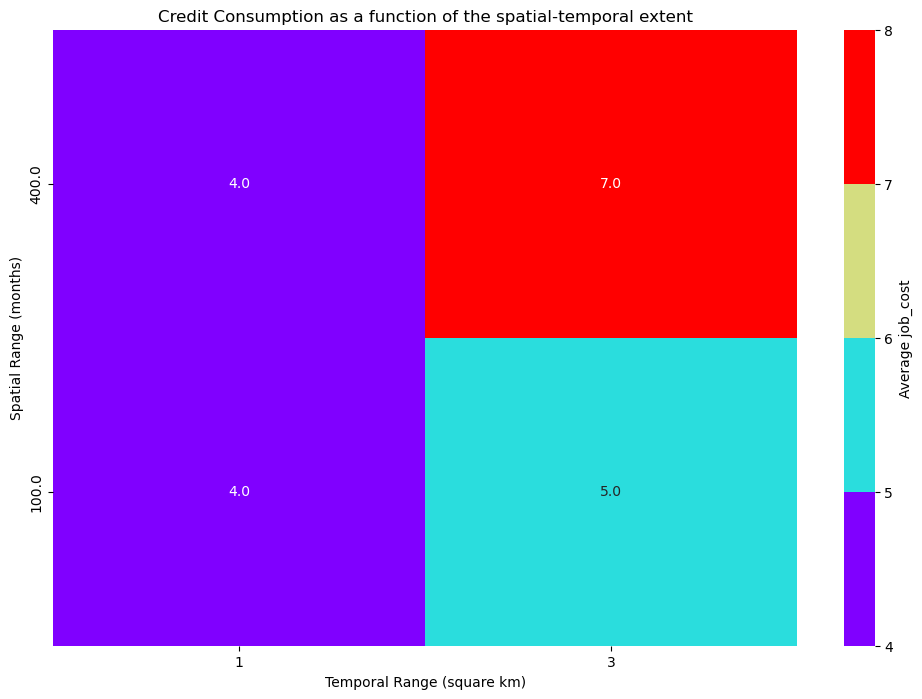

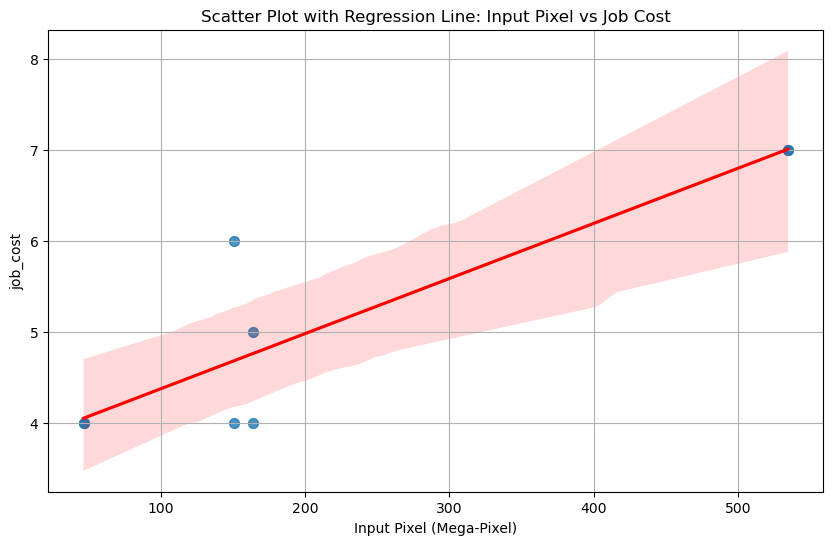

In [8]:
# Plotting

from utils import plot_spatio_temporal_cost_profile, scatter_cost_vs_input_pixel

plot_spatio_temporal_cost_profile(df)
scatter_cost_vs_input_pixel(df)